


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.



## Import packages

In [0]:
import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import glob



Using TensorFlow backend.


# Get the data

In [0]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [0]:
DIR = './'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./cs3-5bou.mid', './cs5-3cou.mid', './cs2-3cou.mid', './cs6-2all.mid', './cs3-4sar.mid', './cs1-6gig.mid', './cs1-1pre.mid', './cs6-3cou.mid', './cs5-6gig.mid', './cs5-5gav.mid', './cs4-1pre.mid', './cs2-1pre.mid', './cs4-2all.mid', './cs1-4sar.mid', './cs5-2all.mid', './cs4-6gig.mid', './cs3-6gig.mid', './cs6-4sar.mid', './cs1-2all.mid', './cs1-3cou.mid', './cs4-5bou.mid', './cs6-6gig.mid', './cs5-1pre.mid', './cs6-1pre.mid', './cs6-5gav.mid', './cs2-6gig.mid', './cs2-2all.mid', './cs3-2all.mid', './cs5-4sar.mid', './cs2-4sar.mid', './cs2-5men.mid', './cs4-3cou.mid', './cs4-4sar.mid', './cs1-5men.mid', './cs3-1pre.mid', './cs3-3cou.mid']


## Read and convert all MIDI files

In [0]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 52, start: 0.720000, end: 0.920000, duration: 0.200000
pitch: 53, start: 0.920000, end: 1.120000, duration: 0.200000
pitch: 55, start: 1.120000, end: 1.520000, duration: 0.400000
pitch: 48, start: 1.520000, end: 1.720000, duration: 0.200000
pitch: 47, start: 1.720000, end: 1.920000, duration: 0.200000
pitch: 48, start: 1.920000, end: 2.320000, duration: 0.400000
pitch: 60, start: 2.320000, end: 2.720000, duration: 0.400000
pitch: 59, start: 2.720000, end: 3.120000, duration: 0.400000
pitch: 57, start: 3.120000, end: 3.320000, duration: 0.200000
pitch: 59, start: 3.320000, end: 3.520000, duration: 0.200000
pitch: 55, start: 3.520000, end: 3.920000, duration: 0.400000
pitch: 50, start: 3.920000, end: 4.120000, duration: 0.200000
pitch: 52, start: 4.120000, end: 4.320000, duration: 0.200000
pitch: 53, start: 4.320000, end: 4.720000, duration: 0.400000
pitch: 47, start: 4.720000, end: 4.920000, duration: 0.200000
pitch: 45, start: 4.920000, end: 5.120000, duration: 0.200000
pitch: 4

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [0]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(872, 79)
(352, 79)
(580, 79)


In [0]:
np.array(X_list).shape

(36,)

## Display the set of notes over time for a specific track 

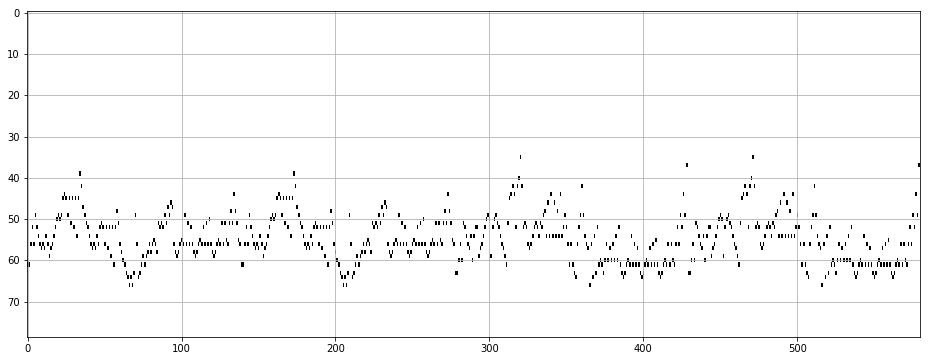

In [0]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

In [0]:
X_train_list = []
y_train_list = []

X_train_list = [X_list[i][t:t+sequence_length] for i in range(len(X_list)) for t in range(len(X_list[i])-sequence_length)]
y_train_list = [X_list[i][t+ sequence_length] for i in range(len(X_list)) for t in range(len(X_list[i])-sequence_length)]
  

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23781, 20, 79)
y_train.shape: (23781, 79)


# Training the language model

The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- a first layer of `LSTM` with $n_a$=256
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a second layer of `LSTM` with $n_a$=256
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a third layer of `LSTM` with $n_a$=256
- a `Dense` layer with 256 units
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a `Dense` layer with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

Note that because we will stack two LSTM layers on top of each other (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option `return_sequences=True` that has to be given to the first LSTM.

This is not the case of the second LSTM since we are only interrest in its final prediction (hence `return_sequences=False` which is the default behaviour).

In [0]:
# --- Create the model
K.clear_session()

model = Sequential()
model.add(LSTM(256,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.3))
    
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
    
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
    
model.add(Dense(n_x,activation='softmax'))
   
    

print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 256)           344064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     


In [0]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=64)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30





23781/23781 [==============================] - 57s 2ms/step - loss: 2.9254 - acc: 0.1194
Epoch 2/30
23781/23781 [==============================] - 49s 2ms/step - loss: 2.6020 - acc: 0.1638
Epoch 3/30
23781/23781 [==============================] - 50s 2ms/step - loss: 2.5338 - acc: 0.1873
Epoch 4/30
23781/23781 [==============================] - 50s 2ms/step - loss: 2.4704 - acc: 0.2123
Epoch 5/30
23781/23781 [==============================] - 49s 2ms/step - loss: 2.3945 - acc: 0.2503
Epoch 6/30
23781/23781 [==============================] - 49s 2ms/step - loss: 2.2858 - acc: 0.2997
Epoch 7/30
23781/23781 [==============================] - 49s 2ms/step - loss: 2.1542 - acc: 0.3391
Epoch 8/30
23781/23781 [==============================] - 49s 2ms/step - loss: 2.0129 - acc: 0.3824
Epoch 9/30
23781/23781 [==============================] - 49s 2ms/step - loss: 1.8662 - acc: 0.4

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 2880 sequences used for training.
We denote it by ```pattern```.



In [0]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

5504
(20, 79)
(1, 20, 79)


In [0]:
I=np.eye(79)
note_l = []

prediction_l = []
# --- Generate T_y_generated notes
for note_index in range(T_y_generated):
    pred = model.predict(np.expand_dims(pattern[note_index:,:], 0))
        
    prediction_l.append(pred)
    note = np.argmax(pred, axis=1)
    note_l.append(note)
        
    pattern = np.vstack((pattern, I[:,note].reshape(-1)))
          


### Display the generated sequence

[array([58]), array([53]), array([61]), array([58]), array([59]), array([50]), array([49]), array([47]), array([42]), array([49]), array([59]), array([58]), array([62]), array([54]), array([55]), array([52]), array([61]), array([52]), array([54]), array([50]), array([59]), array([50]), array([52]), array([49]), array([59]), array([58]), array([56]), array([54]), array([49]), array([42]), array([59]), array([50]), array([52]), array([49]), array([57]), array([49]), array([50]), array([47]), array([55]), array([47]), array([49]), array([46]), array([46]), array([40]), array([54]), array([52]), array([50]), array([49]), array([47]), array([38]), array([50]), array([47]), array([40]), array([47]), array([49]), array([50]), array([47]), array([43]), array([49]), array([52]), array([49]), array([50]), array([42]), array([52]), array([49]), array([40]), array([47]), array([50]), array([55]), array([52]), array([54]), array([47]), array([38]), array([50]), array([40]), array([47]), array([49])

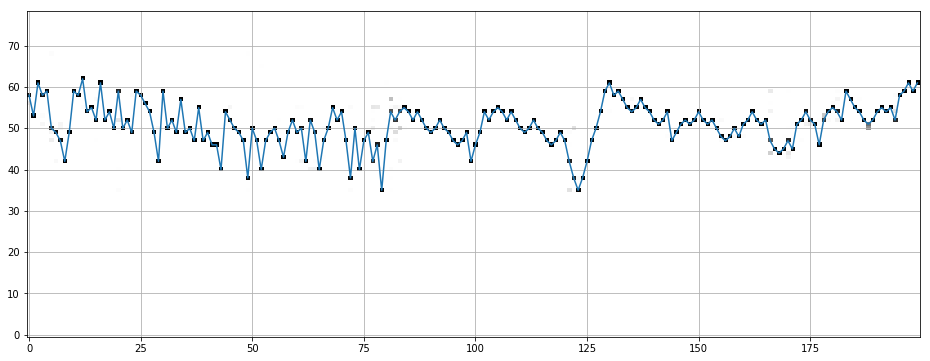

In [0]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)


### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [0]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)

In [0]:
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)